# Use vectorization techniques

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

from src.preprocessing import clean_func, spacy_preprocess_reviews
from src.sts import STSAnalyzer
from src.models import BaselineModel
import numpy as np
from nltk.metrics import jaccard_distance
import os
import pandas as pd
# IMport partial
import nltk

from functools import partial
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk import ngrams
brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk import download
from nltk.stem import PorterStemmer

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# Load a spaCy model (supported languages are "es" and "en") 
nlp = spacy.load('en_core_web_sm')
# spaCy 3.x
nlp.add_pipe("spacy_wordnet", after='tagger')

import textdistance
from src.fe_utils import *

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics.pairwise import paired_manhattan_distances
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics.pairwise import cosine_distances

from sklearn.feature_extraction.text import TfidfVectorizer

prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)
INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]

def train_and_test(model, grid, X_train, y_train, X_test, y_test):
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pearsonr_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic, greater_is_better=True)

    grid = GridSearchCV(pipe, grid, cv=10, scoring=pearsonr_scorer, verbose=10, n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

    return grid

def get_vectorized_distances(vectorizer, X_train, X_test):
    from sklearn.metrics.pairwise import paired_cosine_distances
    from sklearn.metrics.pairwise import paired_euclidean_distances

    X_train_s1 = X_train.iloc[:, 0]
    X_train_s2 = X_train.iloc[:, 1]

    tfidf = vectorizer
    tfidf.fit(pd.concat([X_train_s1, X_train_s2]))
    X_train_tfidf_s1 = tfidf.transform(X_train_s1).todense()
    X_train_tfidf_s2 = tfidf.transform(X_train_s2).todense()

    X_test_s1 = X_test.iloc[:, 0]
    X_test_s2 = X_test.iloc[:, 1]

    X_test_tfidf_s1 = tfidf.transform(X_test_s1).todense()
    X_test_tfidf_s2 = tfidf.transform(X_test_s2).todense()


    # print("Cosine similarity")
    df_dists_train = pd.DataFrame()
    df_dists_test = pd.DataFrame()

    cos_dist_train = paired_cosine_distances(np.asarray(X_train_tfidf_s1), np.asarray(X_train_tfidf_s2)).reshape(-1, 1)
    cos_dist_test = paired_cosine_distances(np.asarray(X_test_tfidf_s1), np.asarray(X_test_tfidf_s2)).reshape(-1, 1)

    df_dists_train["cosine"] = 1 - cos_dist_train.reshape(-1)
    df_dists_test["cosine"] = 1 - cos_dist_test.reshape(-1)

    euc_dist_train = paired_euclidean_distances(np.asarray(X_train_tfidf_s1), np.asarray(X_train_tfidf_s2)).reshape(-1, 1)
    euc_dist_test = paired_euclidean_distances(np.asarray(X_test_tfidf_s1), np.asarray(X_test_tfidf_s2)).reshape(-1, 1)

    df_dists_train["euclidean"] = euc_dist_train.reshape(-1)
    df_dists_test["euclidean"] = euc_dist_test.reshape(-1)

    man_dist_train = paired_manhattan_distances(np.asarray(X_train_tfidf_s1), np.asarray(X_train_tfidf_s2)).reshape(-1, 1)
    man_dist_test = paired_manhattan_distances(np.asarray(X_test_tfidf_s1), np.asarray(X_test_tfidf_s2)).reshape(-1, 1)

    df_dists_train["manhattan"] = man_dist_train.reshape(-1)
    df_dists_test["manhattan"] = man_dist_test.reshape(-1)

    avg_s1_train = np.mean(X_train_tfidf_s1, axis=1)
    avg_s2_train = np.mean(X_train_tfidf_s2, axis=1)

    avg_s1_test = np.mean(X_test_tfidf_s1, axis=1)
    avg_s2_test = np.mean(X_test_tfidf_s2, axis=1)

    df_dists_train["avg_s1"] = avg_s1_train
    df_dists_train["avg_s2"] = avg_s2_train

    df_dists_test["avg_s1"] = avg_s1_test
    df_dists_test["avg_s2"] = avg_s2_test


    return df_dists_train, df_dists_test

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Data

In [73]:
import pandas as pd
sts = STSAnalyzer(preprocess_fun=prep_func, model=BaselineModel(),
                  ls_files=LS_FILES_TRAIN, input_path=TRAIN_PATH)
df = sts.load_data()

sts_test = STSAnalyzer(preprocess_fun=prep_func, model=BaselineModel(),
                  ls_files=LS_FILES_TEST, input_path=TEST_PATH)
df_test = sts_test.load_data()

# Load Features

In [104]:
df_features_train = pd.read_csv("features/all_features_train.csv")
df_features_test = pd.read_csv("features/all_features_test.csv")

X_train_feats = df_features_train.drop(columns=["gs", "file"])
y_train = df_features_train["gs"]

idf_cols = [col for col in X_train_feats.columns if "idf" in col]
X_train_feats = X_train_feats.drop(columns=["path"] + idf_cols)

X_test_feats = df_features_test.drop(columns=["gs", "file"])
y_test = df_features_test["gs"]
X_test_feats = X_test_feats.drop(columns=["path"] + idf_cols)


df_features_train

,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,overlap_n_1,cosine_n_1,jaccard_n_2,dice_n_2,overlap_n_2,cosine_n_2,jaccard_n_3,dice_n_3,overlap_n_3,cosine_n_3,jaccard_n_4,dice_n_4,overlap_n_4,cosine_n_4,jaccard_n_5,dice_n_5,overlap_n_5,cosine_n_5,jaccard_n_1_spacy,dice_n_1_spacy,overlap_n_1_spacy,cosine_n_1_spacy,jaccard_n_2_spacy,dice_n_2_spacy,overlap_n_2_spacy,cosine_n_2_spacy,jaccard_n_3_spacy,dice_n_3_spacy,overlap_n_3_spacy,cosine_n_3_spacy,jaccard_n_4_spacy,dice_n_4_spacy,overlap_n_4_spacy,cosine_n_4_spacy,jaccard_n_5_spacy,dice_n_5_spacy,overlap_n_5_spacy,cosine_n_5_spacy,wup_idf,path_idf,lch_idf,lin_idf,wup,path,lch,lin,jaccard_n_1_stop,dice_n_1_stop,overlap_n_1_stop,cosine_n_1_stop,jaccard_n_2_stop,dice_n_2_stop,overlap_n_2_stop,cosine_n_2_stop,jaccard_n_3_stop,dice_n_3_stop,overlap_n_3_stop,cosine_n_3_stop,jaccard_n_4_stop,dice_n_4_stop,overlap_n_4_stop,cosine_n_4_stop,jaccard_n_5_stop,dice_n_5_stop,overlap_n_5_stop,cosine_n_5_stop,jaccard_n_1_stem,dice_n_1_stem,overlap_n_1_stem,cosine_n_1_stem,jaccard_n_2_stem,dice_n_2_stem,overlap_n_2_stem,cosine_n_2_stem,jaccard_n_3_stem,dice_n_3_stem,overlap_n_3_stem,cosine_n_3_stem,jaccard_n_4_stem,dice_n_4_stem,overlap_n_4_stem,cosine_n_4_stem,jaccard_n_5_stem,dice_n_5_stem,overlap_n_5_stem,cosine_n_5_stem,file,gs
0,75,105,0.738007,0.865225,0.919135,0.006369,104,0.548387,0.708333,0.772727,0.710806,0.378378,0.549020,0.608696,0.551677,0.324324,0.489796,0.545455,0.492366,0.305556,0.468085,0.523810,0.470757,0.285714,0.444444,0.500000,0.447214,0.562500,0.720000,0.900000,0.734847,0.533333,0.695652,0.888889,0.712697,0.500,0.666667,0.875000,0.686406,0.461538,0.631579,0.857143,0.654654,0.416667,0.588235,0.833333,0.615457,23.196118,20.990641,48.063633,12.488635,9.399643,8.495833,25.844144,6.706810,0.500000,0.666667,0.700000,0.667424,0.263158,0.416667,0.416667,0.416667,0.222222,0.363636,0.363636,0.363636,0.176471,0.3,0.3,0.300000,0.125000,0.222222,0.222222,0.222222,0.562500,0.720000,0.900000,0.734847,0.095238,0.173913,0.222222,0.178174,0.050000,0.095238,0.125000,0.098058,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000,0.000000,MSRpar,4.00
1,24,53,0.670886,0.738972,0.843383,0.015873,50,0.444444,0.615385,0.727273,0.622799,0.136364,0.240000,0.300000,0.244949,0.045455,0.086957,0.111111,0.089087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.444444,0.615385,0.800000,0.632456,0.222222,0.363636,0.500000,0.377964,0.125,0.222222,0.333333,0.235702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.259490,13.458484,25.830211,6.830353,5.526786,4.492857,15.490311,4.224677,0.375000,0.545455,0.600000,0.547723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.444444,0.615385,0.800000,0.632456,0.100000,0.181818,0.250000,0.188982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000,0.000000,MSRpar,3.75
2,27,56,0.464865,0.782203,0.782203,0.010989,39,0.363636,0.533333,0.533333,0.533333,0.214286,0.352941,0.375000,0.353553,0.103448,0.187500,0.200000,0.187867,0.071429,0.133333,0.142857,0.133631,0.037037,0.071429,0.076923,0.071611,0.384615,0.555556,0.625000,0.559017,0.066667,0.125000,0.142857,0.125988,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.899164,10.503088,38.100192,13.083557,7.003509,5.863095,23.903266,6.756503,0.285714,0.444444,0.666667,0.471405,0.100000,0.181818,0.250000,0.188982,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.384615,0.555556,0.625000,0.559017,0.142857,0.250000,0.285714,0.251976,0.076923,0.142857,0.166667,0.144338,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000,0.000000,MSRpar,2.80
3,129,133,0.833856,0.901976,0.941186,0.007407,133,0.655172,0.791667,0.950000,0.802897,0.600000,0.750000,0.900000,0.760639,0.586207,0.739130,0.894737,0.750568,0.571429,0.727273,0.888889,0.739600,0

# Preprocess Original Features

In [75]:
print("- Tokenized (list)")
df_prep = df[["sent1", "sent2"]].copy()
df_prep["sent1"] = df_prep["sent1"].apply(lambda x: ' '.join(prep_func(x, out_set=False)))
df_prep["sent2"] = df_prep["sent2"].apply(lambda x: ' '.join(prep_func(x, out_set=False)))
        

- Tokenized (list)


In [76]:
df_prep_test = df_test[["sent1", "sent2"]].copy()
df_prep_test["sent1"] = df_prep_test["sent1"].apply(lambda x: ' '.join(prep_func(x, out_set=False)))
df_prep_test["sent2"] = df_prep_test["sent2"].apply(lambda x: ' '.join(prep_func(x, out_set=False)))

In [77]:
X_train_vec = df_prep.copy()
# y_train = df["gs"].copy()

X_test_vec = df_prep_test.copy()
# y_test = df_test["gs"].copy()

# Apply Cross Validation

In [78]:
def add_vectorized_dists(X_train_vec, X_test_vec, X_train_feats, X_test_feats, vectorizer=TfidfVectorizer()):

    X_dists_train, X_dists_test = get_vectorized_distances(vectorizer, X_train_vec, X_test_vec)

    X_train = pd.concat([X_dists_train.reset_index(drop=True), 
                         X_train_feats.reset_index(drop=True)], axis=1)
    X_test = pd.concat([X_dists_test.reset_index(drop=True), 
                         X_test_feats.reset_index(drop=True)], axis=1)
    return X_train, X_test

In [79]:
from sklearn.linear_model import Lasso

def train_and_test(model, grid, X_train, y_train, X_test, y_test):
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pearsonr_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic, greater_is_better=True)

    grid = GridSearchCV(pipe, grid, cv=10, scoring=pearsonr_scorer, verbose=10, n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

    return grid

# model = Lasso(max_iter=100000, tol=0.01, random_state=0)
# grid = {'model__alpha': np.linspace(0.00001, 0.01, 100),}

# lasso_gscv_par = train_and_test(model, grid, X_train_feats, y_train, X_test_feats, y_test)

# # Get variables with non-zero coefficients
# pos_coef_par = lasso_gscv_par.best_estimator_.named_steps['model'].coef_ > 0
# pos_coef_par = X_train_feats.columns[pos_coef_par]

# X_train_feats_filt = X_train_feats[pos_coef_par]
# X_test_feats_filt = X_test_feats[pos_coef_par]

In [93]:
from sklearn.model_selection import KFold, ParameterGrid

cv = KFold(n_splits=10, random_state=42, shuffle=True)

d_out = {}
forest_param_grid = {'n_estimators': [200, 300], 
                     'min_samples_leaf': [2, 4, 6],
                    'n_jobs': [-1]}

# convert grid in list of dictionnary
param_combinations = ParameterGrid(forest_param_grid)

for params in param_combinations:
    print("Params: ", params)
    i = 0
    ls_scores = []
    for train_index, test_index in cv.split(X_train_feats):

        X_train, X_test = add_vectorized_dists(X_train_vec.iloc[train_index], X_train_vec.iloc[test_index],
                                            X_train_feats.iloc[train_index], X_train_feats.iloc[test_index])
        
        rf = RandomForestRegressor(n_estimators=params["n_estimators"], min_samples_leaf=params["min_samples_leaf"],
                                    random_state=42)
        pipe = Pipeline([('scaler', StandardScaler()), ('model', rf)])
        pipe.fit(X_train, y_train.iloc[train_index])
        # print(y_train.iloc[train_index])
        y_pred = pipe.predict(X_test)
        # print(y_pred)
        score = pearsonr(y_pred, y_train.iloc[test_index].values).statistic
        ls_scores.append(score)

        i += 1
    print(np.mean(ls_scores))
    d_out[i] = params
    d_out[i]["score"] = np.mean(ls_scores)


# pd.DataFrame(d_out)

Params:  {'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}
0.8567252092982134
Params:  {'min_samples_leaf': 2, 'n_estimators': 300, 'n_jobs': -1}
0.8566866972056338
Params:  {'min_samples_leaf': 4, 'n_estimators': 200, 'n_jobs': -1}
0.854599687007279
Params:  {'min_samples_leaf': 4, 'n_estimators': 300, 'n_jobs': -1}
0.8541861575394846
Params:  {'min_samples_leaf': 6, 'n_estimators': 200, 'n_jobs': -1}
0.8515724963540645
Params:  {'min_samples_leaf': 6, 'n_estimators': 300, 'n_jobs': -1}


KeyboardInterrupt: 

In [105]:
from sklearn.linear_model import LassoCV

X_train, X_test = add_vectorized_dists(X_train_vec, X_test_vec,
                                        X_train_feats, X_test_feats)
rf = RandomForestRegressor(random_state=42, **{'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1})
pipe = Pipeline([('scaler', StandardScaler()), ('model', rf)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
pearsonr(y_pred, y_test).statistic

0.7399715766021404

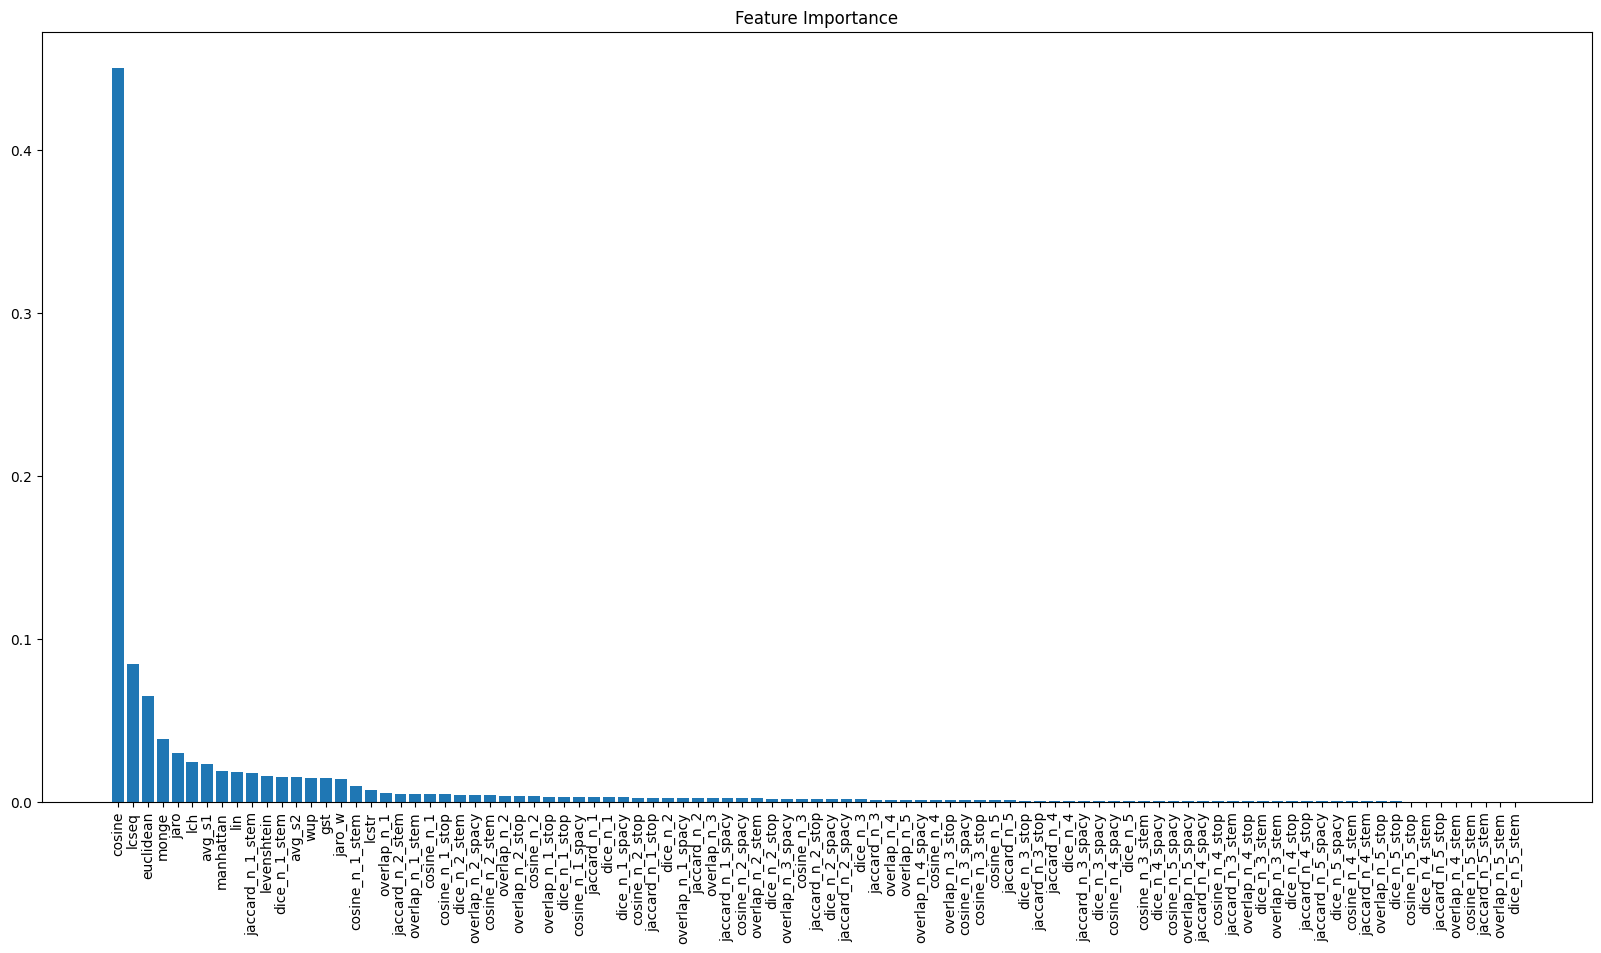

In [106]:
def plot_feature_importances(rf, df):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [df.columns[i] for i in indices]
    plt.figure(figsize=(20, 10))
    plt.title("Feature Importance")
    plt.bar(range(df.shape[1]), importances[indices])
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(pipe.named_steps["model"], X_train)

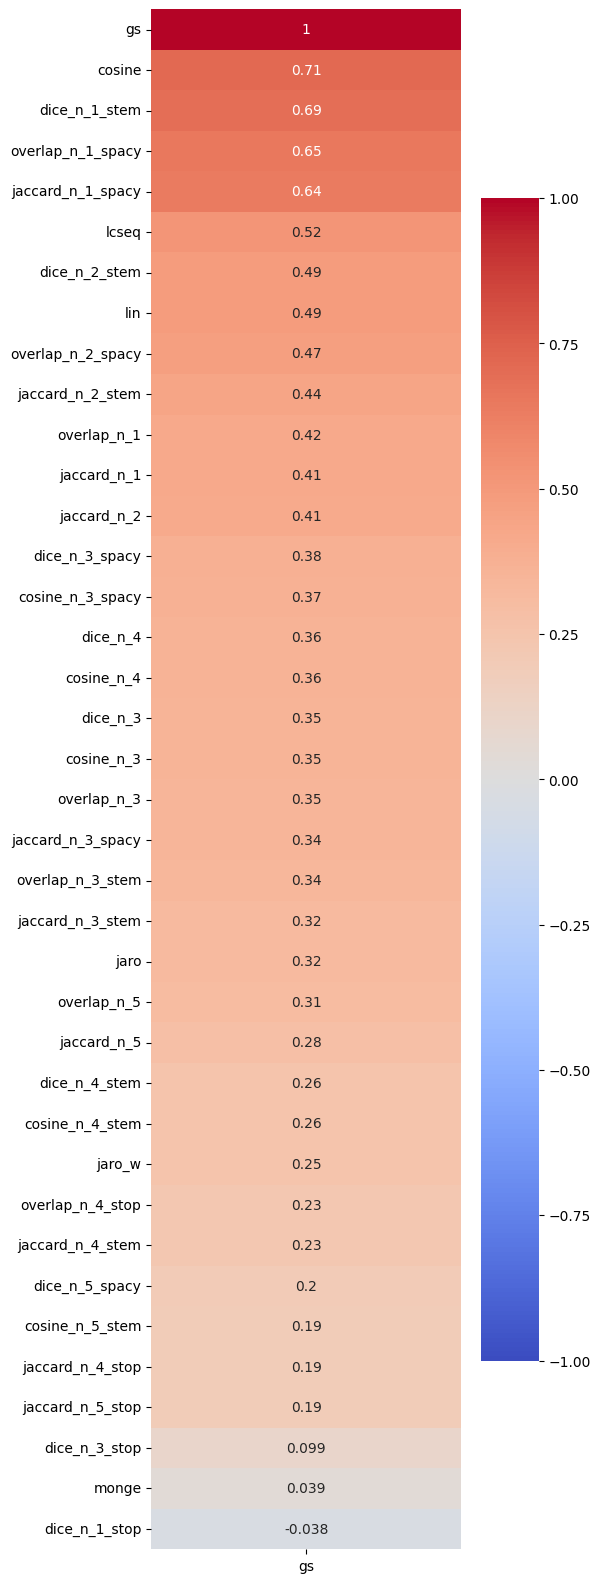

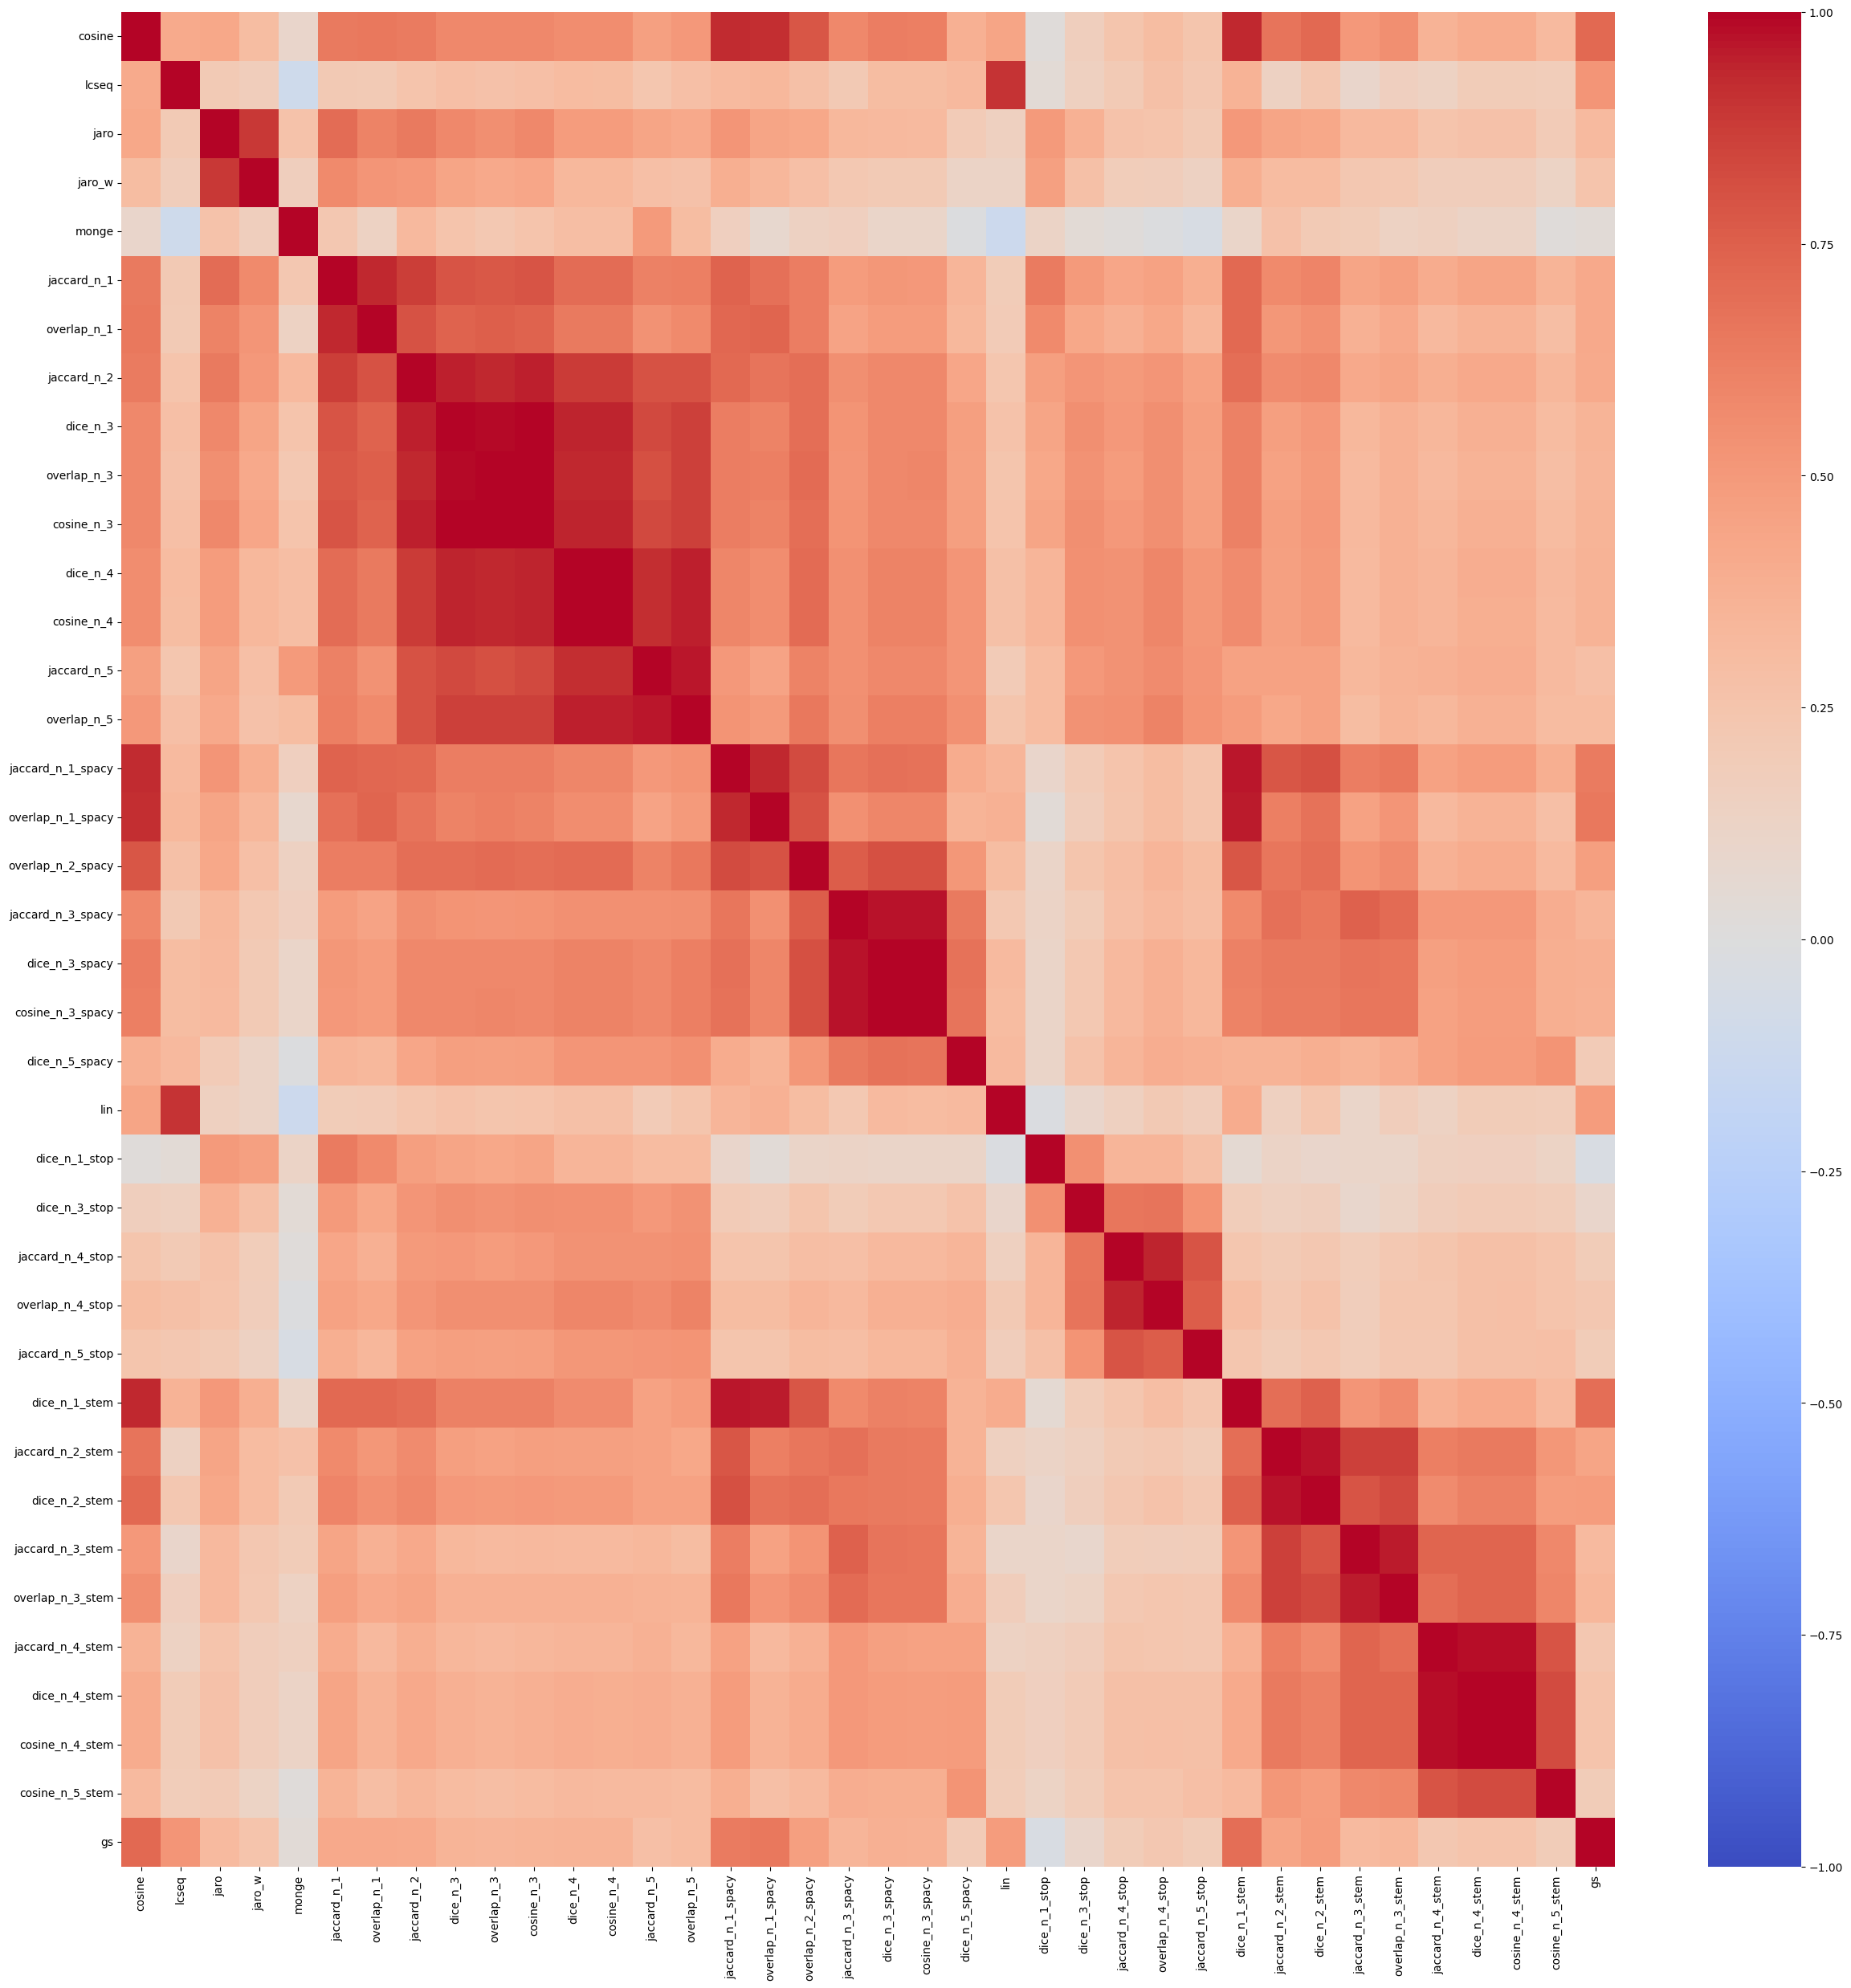

In [35]:
df_corr = X_train.copy()
df_corr["gs"] = y_train
# Plot heatmap of correlations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_corr = pd.DataFrame(sc.fit_transform(df_corr), columns=df_corr.columns)
plt.figure(figsize=(5, 20))
sns.heatmap(df_corr.corr()[["gs"]].sort_values(by="gs", ascending=False), annot=True, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(30, 30))
sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()


<Axes: xlabel='cosine', ylabel='gs'>

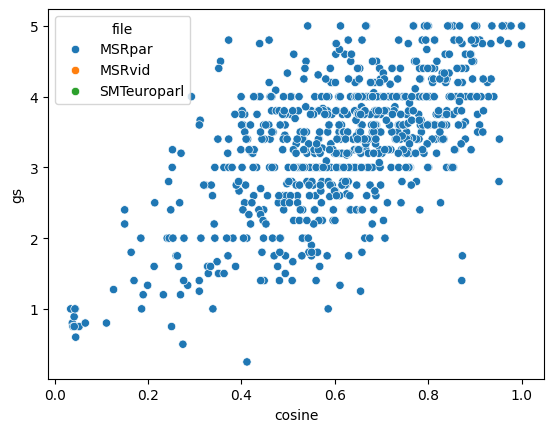

In [43]:
sns.scatterplot(x=X_train["cosine"][df["file"] == "MSRpar"], y=y_train, hue=df["file"])

In [70]:
pearsonr(X_test["dice_n_1_stem"], y_test).statistic

0.6625668408676987

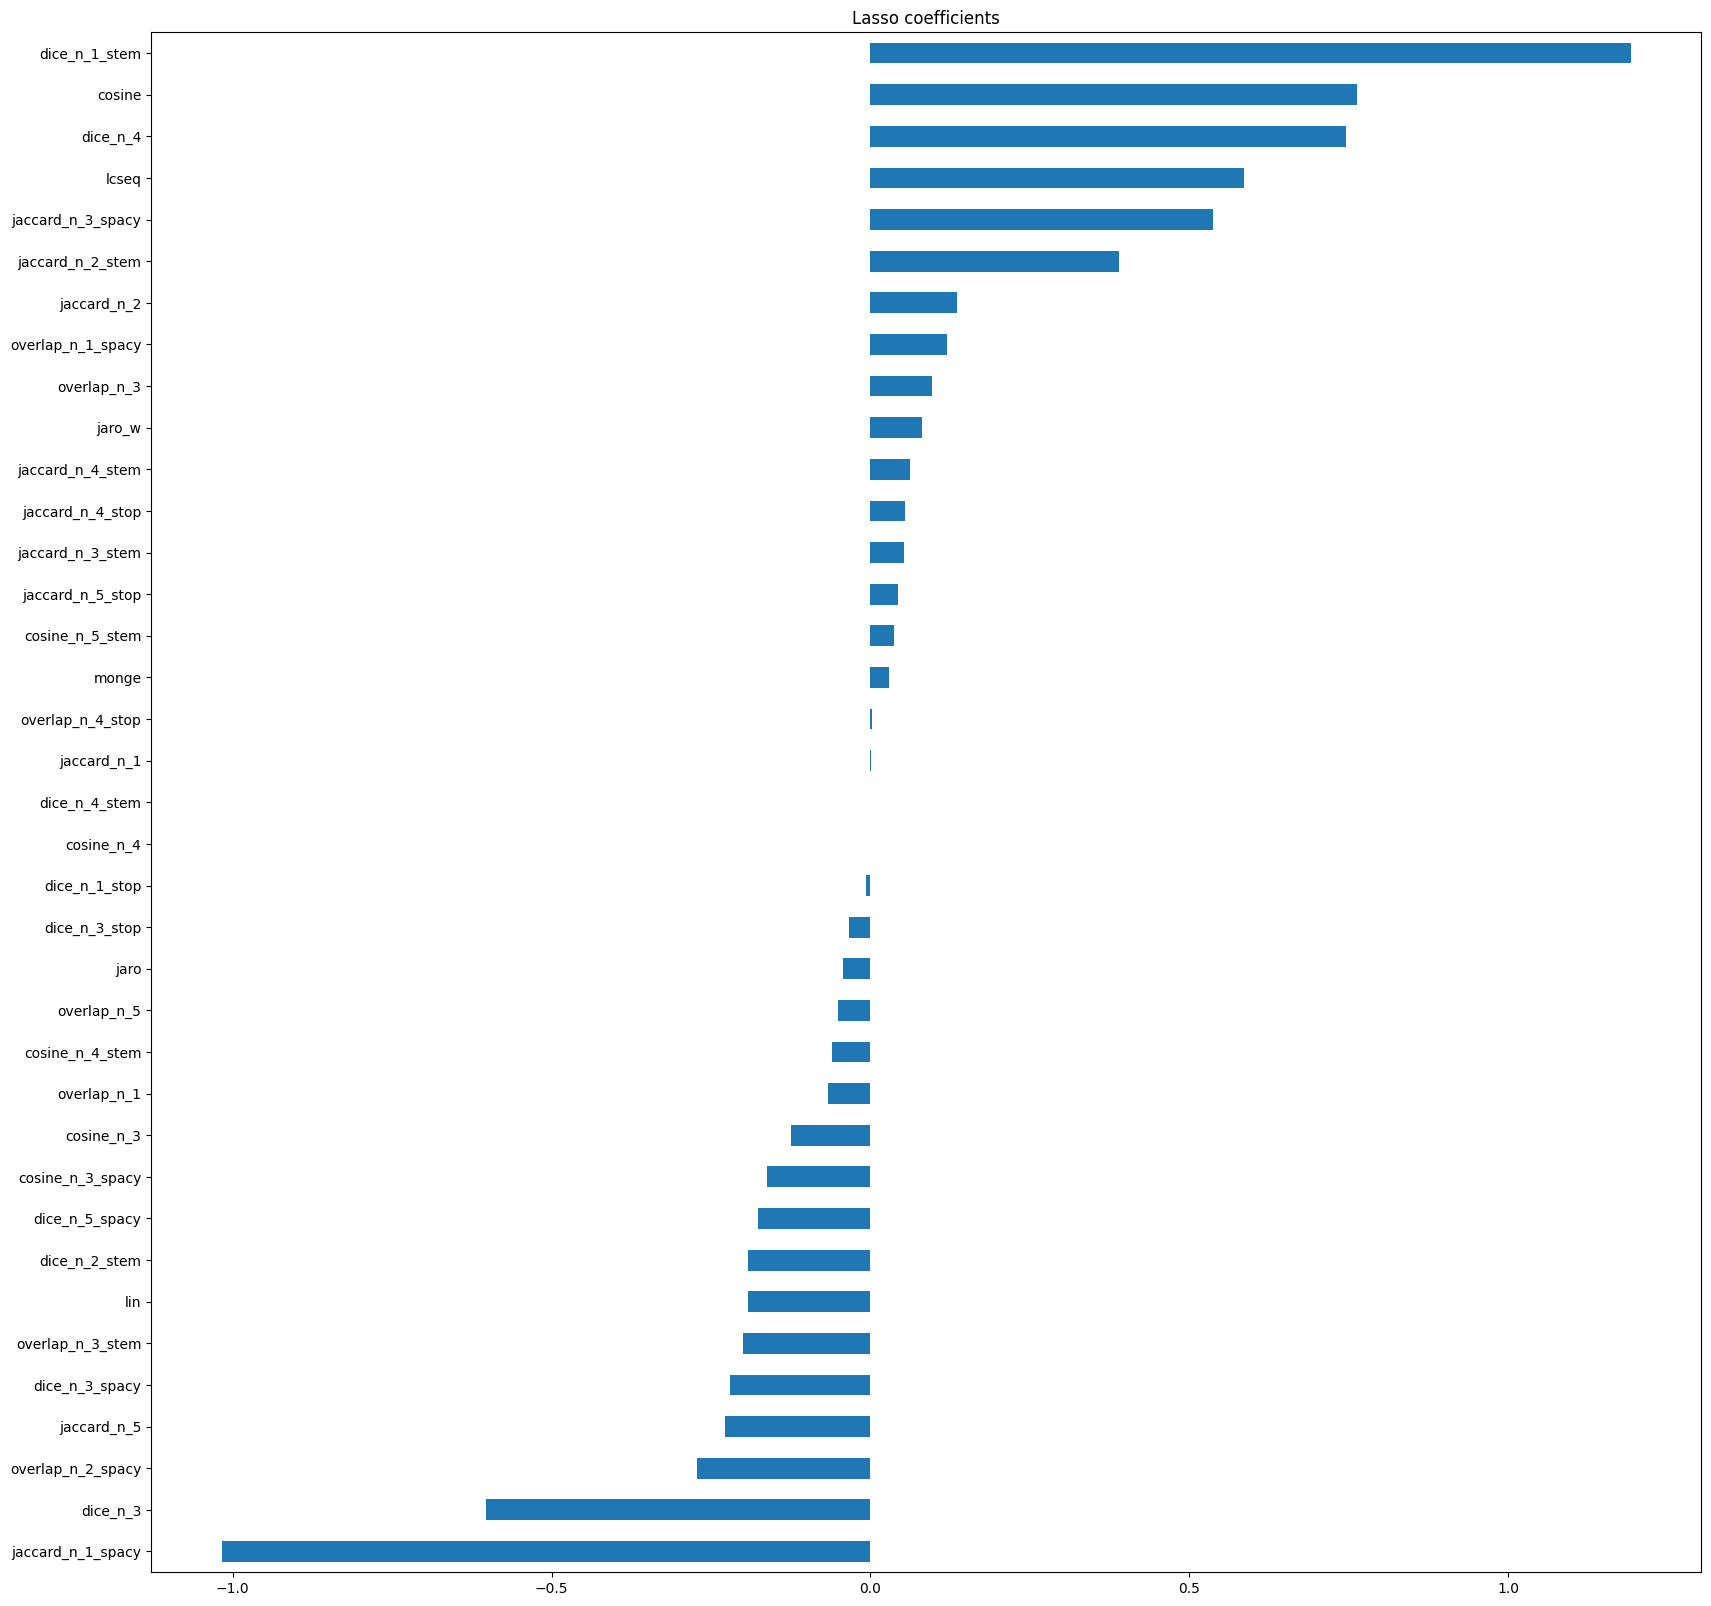

In [66]:
# Create function to plot lasso coefficients
def plot_lasso_coef(model, X_train, figsize=(20, 10)):
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef = coef.sort_values()
    plt.figure(figsize=figsize)
    coef.plot(kind='barh')
    plt.title('Lasso coefficients')
    plt.show()

# get lasso from pipe
model = pipe.named_steps["model"]

plot_lasso_coef(model, X_train, (20, 20))

<Axes: xlabel='cosine', ylabel='gs'>

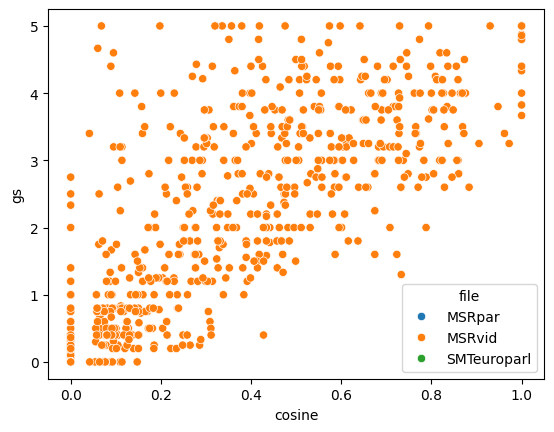

In [44]:
sns.scatterplot(x=X_train["cosine"][df["file"] == "MSRvid"], y=y_train, hue=df["file"])

<Axes: xlabel='cosine', ylabel='gs'>

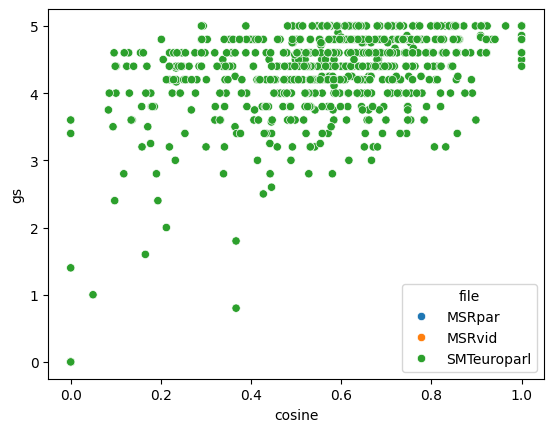

In [45]:
sns.scatterplot(x=X_train["cosine"][df["file"] == "SMTeuroparl"], y=y_train, hue=df["file"])

In [ ]:
df_corr = pd.DataFrame(sc.fit_transform(df_corr), columns=df_corr.columns)
plt.figure(figsize=(5, 20))
sns.heatmap(df_corr.corr()[["gs"]].sort_values(by="gs", ascending=False), annot=True, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(30, 30))
sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()

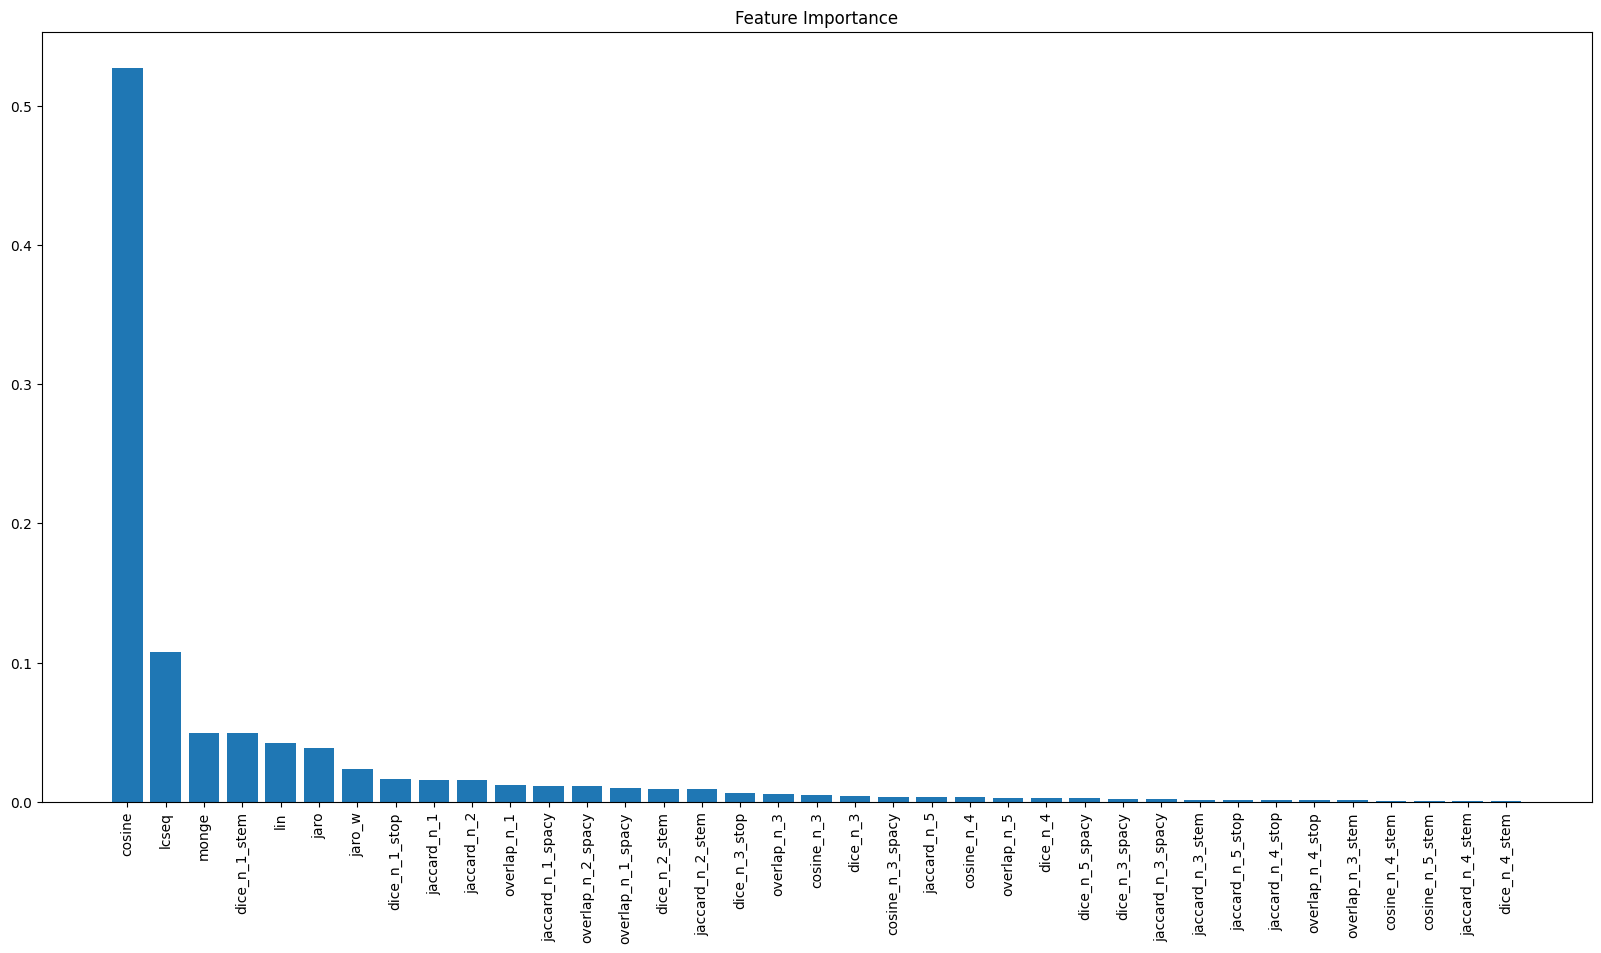

In [17]:
def plot_feature_importances(rf, df):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [df.columns[i] for i in indices]
    plt.figure(figsize=(20, 10))
    plt.title("Feature Importance")
    plt.bar(range(df.shape[1]), importances[indices])
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(rf, X_train)

In [110]:
df_train_par = pd.read_csv('features/MSRpar_features_train.csv')
df_test_par = pd.read_csv('features/MSRpar_features_test.csv')

idf_cols = [col for col in df_train_par.columns if 'idf' in col]

df_train_par = df_train_par.drop(columns=idf_cols)
df_test_par = df_test_par.drop(columns=idf_cols)

X_train_par, X_test_par = df_train_par.drop(columns=["file"]).copy(), df_test_par.drop(columns=["file"]).copy()
y_train_par, y_test_par = X_train_par.pop('gs'), X_test_par.pop('gs')

# model = Lasso(max_iter=100000, tol=0.01, random_state=0)
# grid = {'model__alpha': np.linspace(0.00001, 0.01, 100),}

# lasso_gscv_par = train_and_test(model, grid, X_train_par, y_train_par, X_test_par, y_test_par)

# # Get variables with non-zero coefficients
# pos_coef_par = lasso_gscv_par.best_estimator_.named_steps['model'].coef_ > 0
# pos_coef_par = X_train_par.columns[pos_coef_par]

# X_train_par = X_train_par[pos_coef_par]
# X_test_par = X_test_par[pos_coef_par]

X_train_vec_par = df[df["file"] == "MSRpar"][["sent1", "sent2"]].copy()
X_test_vec_par = df_test[df_test["file"] == "MSRpar"][["sent1", "sent2"]].copy()

forest_param_grid = {'n_estimators': [200, 250, 300], 
                     'min_samples_leaf': [4, 6, 8],
                    'n_jobs': [-1]}

# convert grid in list of dictionnary
param_combinations = ParameterGrid(forest_param_grid)

cv = KFold(n_splits=10, random_state=42, shuffle=True)

for params in param_combinations:
    print("Params: ", params)
    i = 0
    ls_scores = []
    for train_index, test_index in cv.split(X_train_par):

        X_train_sp, X_test_sp = add_vectorized_dists(X_train_vec_par.iloc[train_index], X_train_vec_par.iloc[test_index],
                                            X_train_par.iloc[train_index], X_train_par.iloc[test_index])
        
        rf = RandomForestRegressor(n_estimators=params["n_estimators"], min_samples_leaf=params["min_samples_leaf"],
                                    random_state=42)
        pipe = Pipeline([('scaler', StandardScaler()), ('model', rf)])
        pipe.fit(X_train_sp, y_train.iloc[train_index])
        # print(y_train.iloc[train_index])
        y_pred = pipe.predict(X_test_sp)
        # print(y_pred)
        score = pearsonr(y_pred, y_train.iloc[test_index].values).statistic
        ls_scores.append(score)

        i += 1
    print(np.mean(ls_scores))
    d_out[i] = params
    d_out[i]["score"] = np.mean(ls_scores)

Params:  {'min_samples_leaf': 4, 'n_estimators': 200, 'n_jobs': -1}
0.6137670768338723
Params:  {'min_samples_leaf': 4, 'n_estimators': 250, 'n_jobs': -1}
0.6145469662933432
Params:  {'min_samples_leaf': 4, 'n_estimators': 300, 'n_jobs': -1}
0.6153609753594196
Params:  {'min_samples_leaf': 6, 'n_estimators': 200, 'n_jobs': -1}
0.6141010829992067
Params:  {'min_samples_leaf': 6, 'n_estimators': 250, 'n_jobs': -1}
0.6142576298566279
Params:  {'min_samples_leaf': 6, 'n_estimators': 300, 'n_jobs': -1}
0.6145787963440003
Params:  {'min_samples_leaf': 8, 'n_estimators': 200, 'n_jobs': -1}
0.6107923360875734
Params:  {'min_samples_leaf': 8, 'n_estimators': 250, 'n_jobs': -1}
0.6119942940230756
Params:  {'min_samples_leaf': 8, 'n_estimators': 300, 'n_jobs': -1}
0.6126542480845454


In [137]:
from sklearn.linear_model import LassoCV

X_train_par_def, X_test_par_def = add_vectorized_dists(X_train_vec_par, X_test_vec_par,
                                        X_train_par, X_test_par)
rf = RandomForestRegressor(random_state=42, **{'min_samples_leaf': 4, 'n_estimators': 300, 'n_jobs': -1})
pipe = Pipeline([('scaler', StandardScaler()), ('model', rf)])

pipe.fit(X_train_par_def, y_train_par)
y_pred = pipe.predict(X_test_par_def)
pearsonr(y_pred, y_test_par).statistic

0.6376069904808749

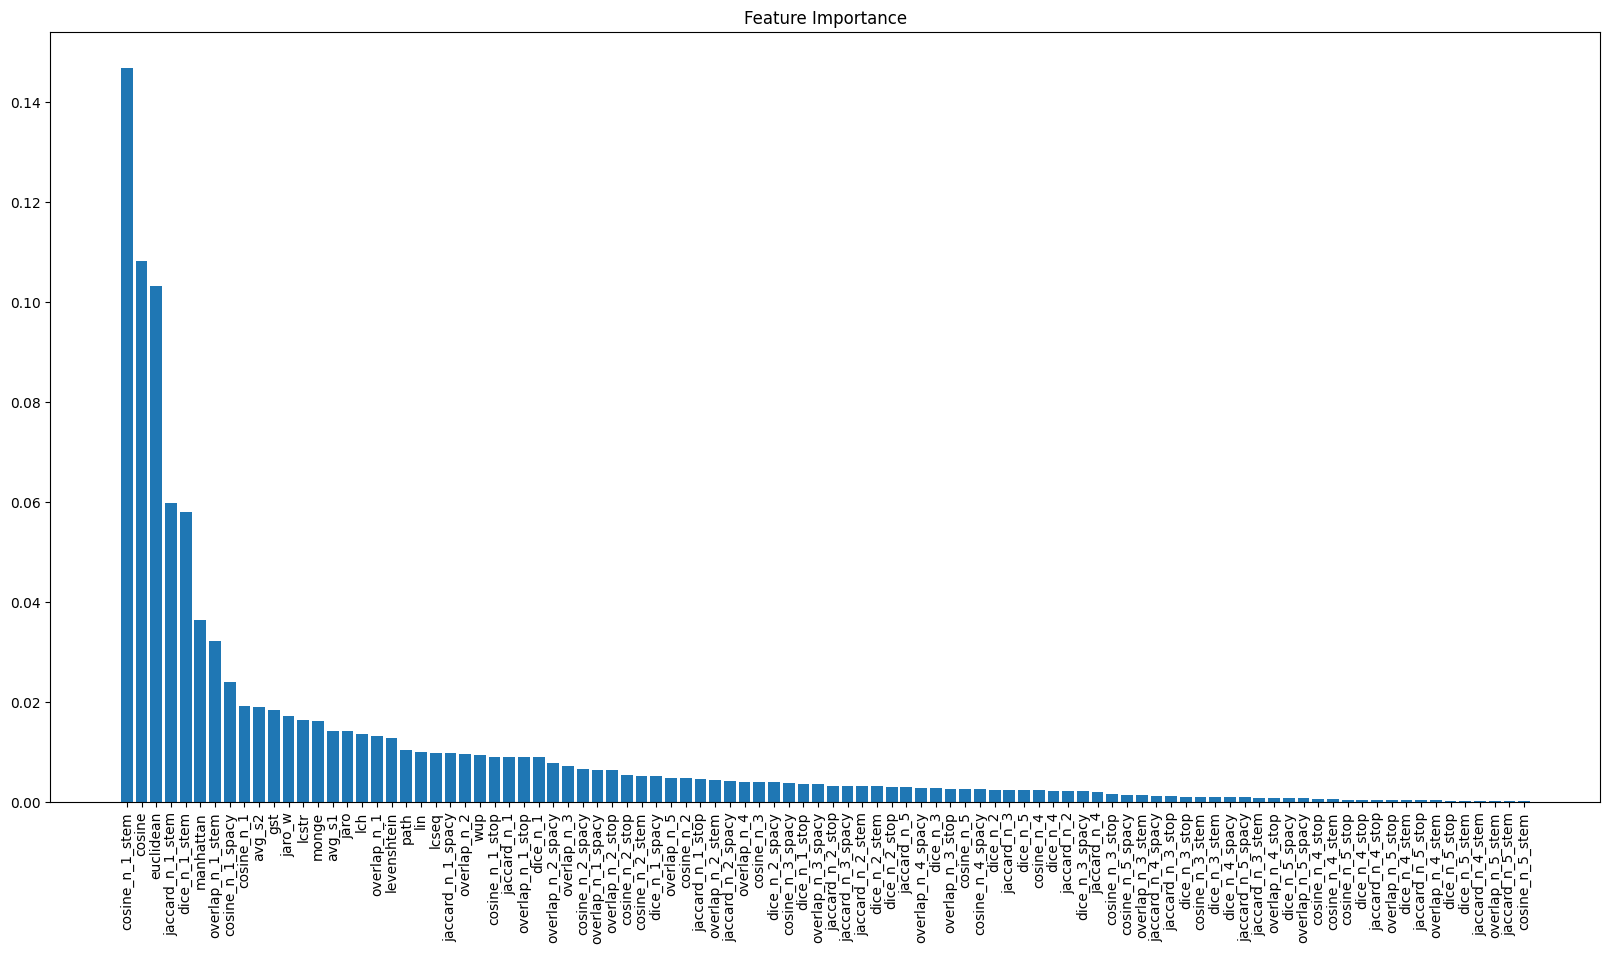

In [139]:
def plot_feature_importances(rf, df):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [df.columns[i] for i in indices]
    plt.figure(figsize=(20, 10))
    plt.title("Feature Importance")
    plt.bar(range(df.shape[1]), importances[indices])
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(rf, X_train_par_def)

In [31]:
X_train_par, X_test_par = add_vectorized_dists(X_train_vec_par, X_test_vec_par,
                                        X_train_par, X_test_par)

rf = RandomForestRegressor(min_samples_leaf=3, n_estimators=400, random_state=42)
rf.fit(X_train_par, y_train_par)
# print(y_train.iloc[train_index])
y_pred = rf.predict(X_test_par)
# print(y_pred)
score = pearsonr(y_pred, y_test_par.values).statistic
print(score)

0.6406119210154937


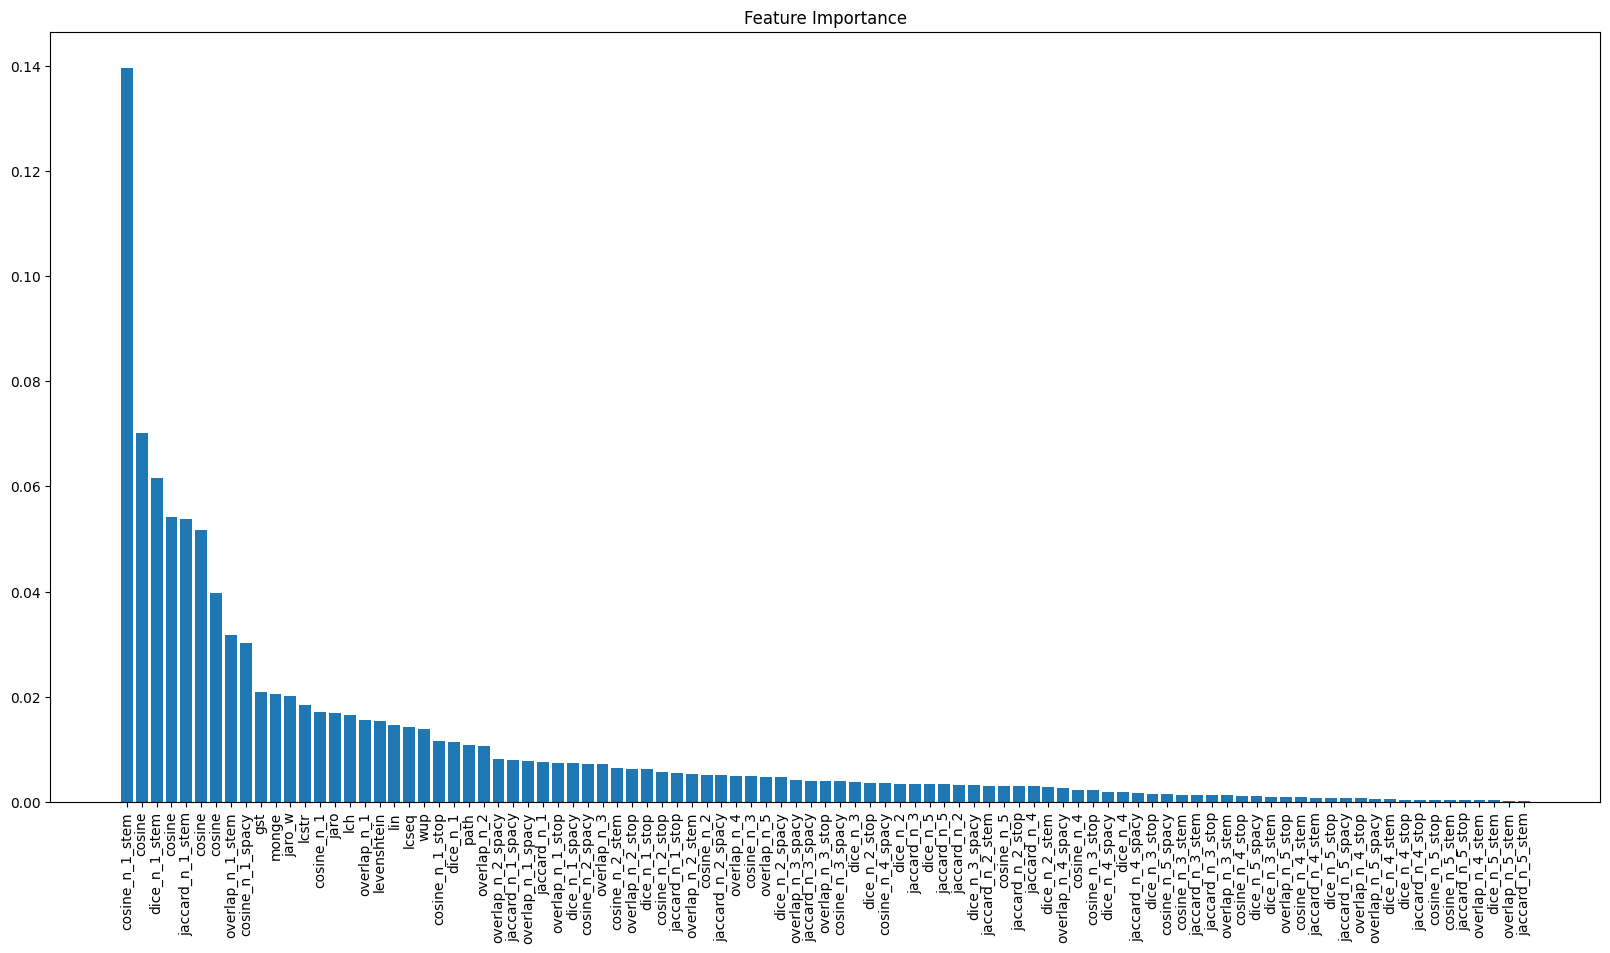

In [26]:
plot_feature_importances(rf, X_train_par)